Install Package

In [ ]:
!pip install wandb

Libraries

In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, MaxPool2D, Dense
import numpy as np
import cv2
import wandb
from wandb.keras import WandbCallback
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

Init Wandb

In [14]:
wandb.init(project="Animal-Detector")

accuracy,▁▂▃▃▄▅▅▅▆▆▆▆▆▇▇▇▇▆▇▇▇▇▇▇▇▇██▇▇██████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▇▆▅▅▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▄▄▄▇▇▅▇▆▇█▅▇▇▇█▆▇▇▅▇▇▇█▇█▇▆▇▇▇▇▇▇▆▇▇▇▇
val_loss,▆▅▄▃▃▂▂▂▁▂▂▁▂▂▂▂▃▃▃▃▄▃▂▃▂▄▄▇▄▄▄▅▅▅▄▆▇▃█▅
accuracy,0.93129
best_epoch,8
best_val_loss,0.75946
epoch,39
loss,0.19122
val_accuracy,0.67857


In [4]:
config = wandb.config
config.learning_rate = 0.001

In [5]:
TRAIN_PATH = "/content/drive/MyDrive/Dataset/Animal/dataset_train"
width = height = 224

Pre-Processing

In [6]:
idg = ImageDataGenerator(
    rescale = 1./255,
    
    # Augmentation
    horizontal_flip = True,
    zoom_range = 0.15,
    rotation_range = 20,
    brightness_range = (0.8, 1.2),
    
    # Validation Split
    validation_split = 0.15    
)

In [7]:
train_data = idg.flow_from_directory(
    TRAIN_PATH,
    target_size = (width, height),
    class_mode = "categorical",
    subset = "training"
)

val_data = idg.flow_from_directory(
    TRAIN_PATH,
    target_size = (width, height),
    class_mode = "categorical",
    subset = "validation"
)

Found 815 images belonging to 5 classes.
Found 140 images belonging to 5 classes.


Model

In [8]:
model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(width, height, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPool2D(),
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPool2D(),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPool2D(),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(5, activation='softmax')
])

In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

Train

In [10]:
model.fit(train_data, validation_data=val_data, epochs=40, callbacks=[WandbCallback()])

Epoch 1/40
26/26 [==============================] - 223s 9s/step - loss: 1.6692 - accuracy: 0.2147 - val_loss: 1.5951 - val_accuracy: 0.3500 - _timestamp: 1647359936.0000 - _runtime: 297.0000
Epoch 2/40
26/26 [==============================] - 31s 1s/step - loss: 1.5032 - accuracy: 0.3607 - val_loss: 1.3325 - val_accuracy: 0.4000 - _timestamp: 1647359967.0000 - _runtime: 328.0000
Epoch 3/40
26/26 [==============================] - 30s 1s/step - loss: 1.3614 - accuracy: 0.4454 - val_loss: 1.2589 - val_accuracy: 0.5286 - _timestamp: 1647359997.0000 - _runtime: 358.0000
Epoch 4/40
26/26 [==============================] - 30s 1s/step - loss: 1.3100 - accuracy: 0.4552 - val_loss: 1.0966 - val_accuracy: 0.5500 - _timestamp: 1647360026.0000 - _runtime: 387.0000
Epoch 5/40
26/26 [==============================] - 30s 1s/step - loss: 1.1161 - accuracy: 0.5521 - val_loss: 1.0753 - val_accuracy: 0.5500 - _timestamp: 1647360056.0000 - _runtime: 417.0000
Epoch 6/40
26/26 [==========================

Save

In [11]:
model.save('animalDetector_model.h5')

Test

In [12]:
TEST_PATH = "/content/drive/MyDrive/Dataset/Animal/dataset_test"

idg = ImageDataGenerator(
    rescale = 1./255
)

test_data = idg.flow_from_directory(
    TEST_PATH,
    target_size = (width, height),
    class_mode = "categorical"
)

model.evaluate(test_data)

Found 173 images belonging to 5 classes.
6/6 [==============================] - 58s 11s/step - loss: 1.1337 - accuracy: 0.6763


[1.1337369680404663, 0.676300585269928]

Confusion Matrix

In [17]:
Y_pred = []

for path in test_data.filepaths:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (width, height))
    image = image / 255
    image = image.reshape(1, width, height, 3)
    Y_pred.append(np.argmax(model.predict(image)))

In [18]:
conf_mat = confusion_matrix(test_data.classes, Y_pred)
print(conf_mat)

[[24  1  8  1  2]
 [ 0 28  3  6  0]
 [ 6  4 16  5  5]
 [ 2  1  1 30  1]
 [ 1  2  0  4 22]]


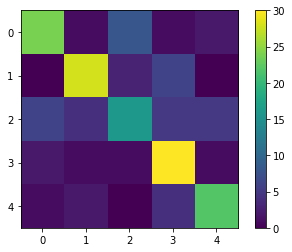

In [22]:
plt.imshow(conf_mat)
plt.colorbar()

Inference

In [13]:
image = cv2.imread("bee.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # cv2 bar khalaf tf
image = cv2.resize(image, (width, height))
image = image / 255 # normalize
image = image.reshape(1, width, height, 3) # 3d -> 4d (batch_size)

result = model.predict(image)

pred = np.argmax(result)
if pred == 0:
    print("Bee 🐝")
elif pred == 1:
    print("Koala 🐨")
elif pred == 2:
    print("Crocodile 🐊")
elif pred == 3:
    print("Crow 🐧")
elif pred == 4:
    print("Zebra 🦓")

Bee 🐝
